In [2]:
setwd('/import/DB/zhang//data')

In [ ]:
library(Seurat)
daa = readRDS('./scRNA.rename.rds')
DefaultAssay(daa) = 'RNA'
library(Seurat)
Idents(daa) = 'celltype'
DimPlot(daa, group.by="celltype", label=T, label.size=5, reduction='umap')
OS = subset(daa,celltype =='T/NK')
DimPlot(OS)
mca2=CreateSeuratObject(OS@assays$RNA@data,assay = "RNA",min.cells =5 ,meta.data = OS@meta.data)
immune.combined = mca2
immune.combined

In [46]:
library(harmony)
DefaultAssay(immune.combined) = 'RNA'
table(OS$orig.ident)
sceList <- SplitObject(immune.combined, split.by = "orig.ident")
single.ob=merge(sceList[[1]],sceList[2:length(sceList)])
DefaultAssay(single.ob) = 'RNA'
scRNA_harmony = single.ob
scRNA_harmony <- NormalizeData(scRNA_harmony) %>% FindVariableFeatures() %>% ScaleData() %>% RunPCA(verbose=FALSE)
##整合
system.time({scRNA_harmony <- RunHarmony(scRNA_harmony, group.by.vars = "orig.ident")})
scRNA_harmony <- RunUMAP(scRNA_harmony, reduction = "harmony", dims = 1:30)
scRNA_harmony <- RunTSNE(scRNA_harmony, reduction = "harmony", dims = 1:30)
scRNA_harmony <- FindNeighbors(scRNA_harmony, reduction = "harmony", dims = 1:30) %>% FindClusters(resolution =  0.1)
##作图
#group_by_cluster


          C1           C2           C3           C4           S1           S2 
        4278         4412         7131         4063          490         1213 
          S3           S4 WH2109002886 WH2109013167 WH2112008442 WH2201006389 
         644         1641         1782          653          529          687 
WH2203005877 
         707 

Centering and scaling data matrix

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony converged after 3 iterations

Warning message:
"Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity"


   user  system elapsed 
 22.497  13.331  58.631 

05:57:11 UMAP embedding parameters a = 0.9922 b = 1.112

05:57:11 Read 28230 rows and found 30 numeric columns

05:57:11 Using Annoy for neighbor search, n_neighbors = 30

05:57:11 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

05:57:19 Writing NN index file to temp file /tmp/RtmpUiYWYy/file39a30509a0329

05:57:19 Searching Annoy index using 1 thread, search_k = 3000

05:57:43 Annoy recall = 100%

05:57:44 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

05:57:48 Initializing from normalized Laplacian + noise (using irlba)

05:57:53 Commencing optimization for 200 epochs, with 1272940 positive edges

05:58:28 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 28230
Number of edges: 1045943

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9616
Number of communities: 7
Elapsed time: 9 seconds


In [47]:
options(repr.plot.width = 12,repr.plot.height = 8)

In [48]:
table(scRNA_harmony$group)


     OS control 
   4358   23872 

In [49]:
options(repr.plot.width = 8,repr.plot.height = 6)

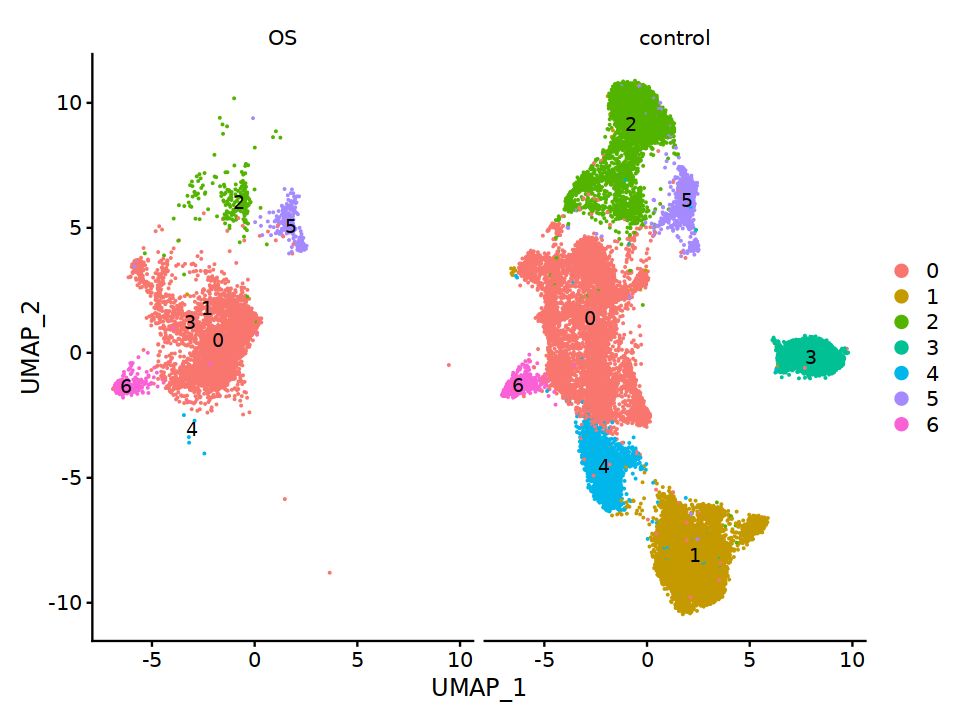

In [50]:
DimPlot(scRNA_harmony, reduction = "umap", split.by = "group",ncol = 2,label = T)

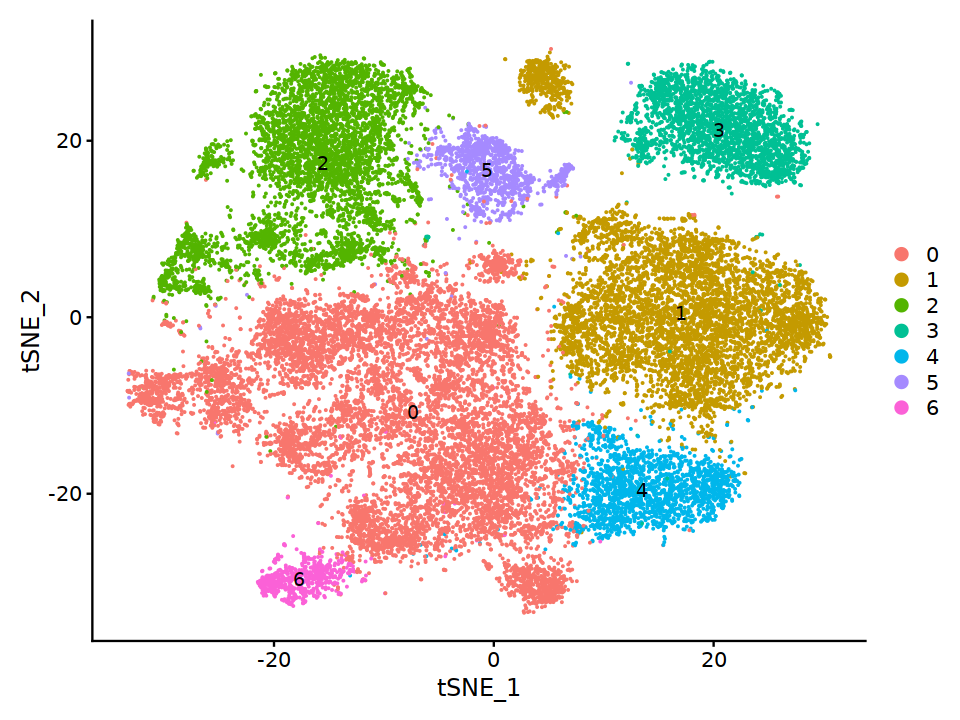

In [51]:
DimPlot(scRNA_harmony, reduction = "tsne", label=T) 

In [52]:
DefaultAssay(scRNA_harmony) = 'RNA'

In [67]:
Idents(scRNA_harmony) = 'seurat_clusters'

In [68]:
scRNA_harmony = subset(scRNA_harmony,idents = c(0,1,2,4,5,6))

In [69]:
SCE = scRNA_harmony

In [70]:
Idents(SCE) = 'seurat_clusters'
DefaultAssay(SCE) = 'RNA'
sce.markers <- FindAllMarkers(object = SCE, only.pos = TRUE, 
                              min.pct = 0.25, 
                              thresh.use = 0.25)
 

library(dplyr) 
# 不同seurat版本的 avg_logFC 不一样 
top5 <- sce.markers %>% group_by(cluster) %>% top_n(5, avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6



In [71]:
write.csv(sce.markers,file = 'NKT.sce.markers.csv')

In [45]:
table(SCE$seurat_clusters)

ERROR: Error in eval(quote(list(...)), env): object 'SCE' not found


In [73]:
library(dplyr) 
# 不同seurat版本的 avg_logFC 不一样 
top5 <- sce.markers %>% group_by(cluster) %>% top_n(5, avg_log2FC)

In [74]:
library(ggplot2)

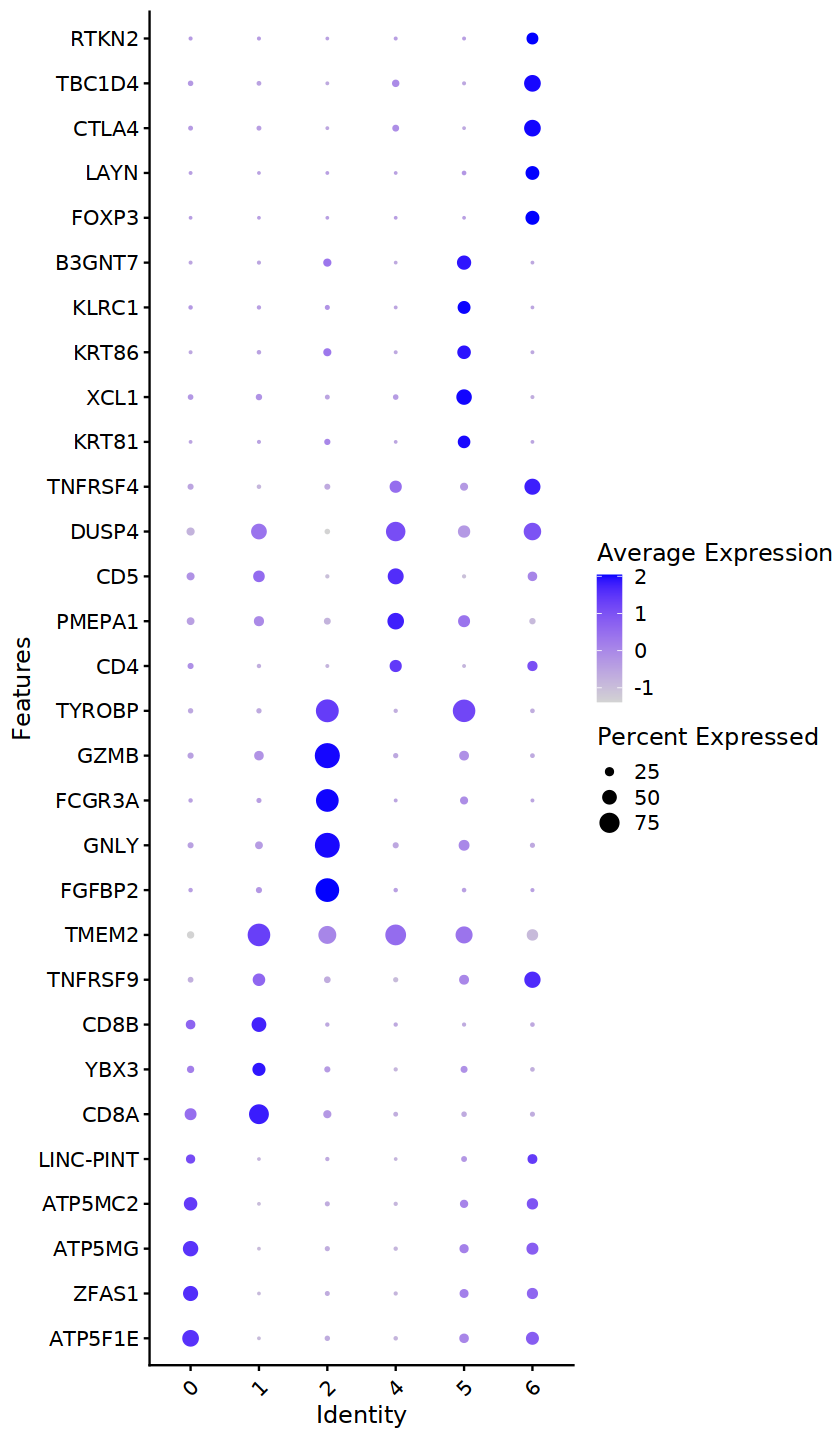

In [75]:
options(repr.plot.height = 12,repr.plot.width = 7)

 DotPlot(SCE, features = unique(top5$gene) ,
 assay='RNA' ) + coord_flip()+ theme(axis.text.x = element_text(angle = 45, 
 vjust = 0.5, hjust=0.5))

In [ ]:
# 4 cd4_tn
# 6 cd4_treg
# 5 2  nk
# 1 cd8 tem
# 3 unknown
# 0 CD8_tn

In [76]:
Idents(SCE)  ='seurat_clusters'

celltype = data.frame(
    cluster = c(0,1,2,4,5,6),
    celltype = c('CD8_tn','cd8_tm','nk',
                'cd4_tn','nk','cd4_treg'
                )
)

for(i in 1:nrow(celltype)){
  SCE@meta.data[which(SCE@meta.data$seurat_clusters == celltype$cluster[i]),'celltype'] <- celltype$celltype[i]}

In [78]:
options(repr.plot.width = 8,repr.plot.height = 5)

In [83]:
SCE1 = SCE

In [84]:
Idents(SCE1) = 'celltype'

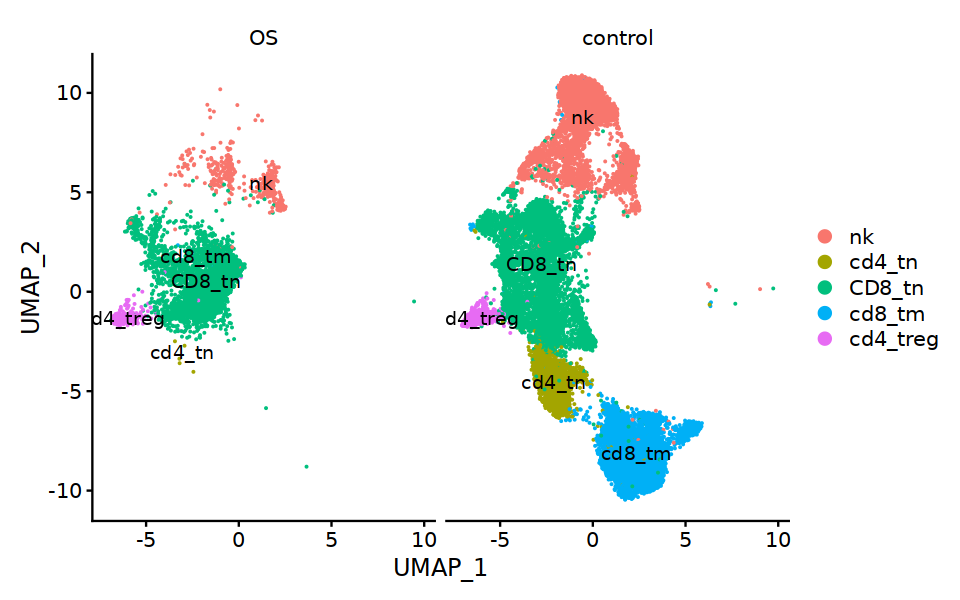

In [85]:
DimPlot(SCE1, reduction = "umap", label=T,split.by = 'group') 

In [86]:
saveRDS(SCE1,file = 'T.rds')

In [3]:
SCE1 = readRDS('T.rds')

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)



In [4]:
SCE1

An object of class Seurat 
19881 features across 25445 samples within 1 assay 
Active assay: RNA (19881 features, 2000 variable features)
 4 dimensional reductions calculated: pca, harmony, umap, tsne

In [5]:
table(SCE1$group,SCE1$celltype)

         
          CD8_tn cd4_tn cd4_treg cd8_tm   nk
  OS        3670      6      208      2  471
  control   6779   1984      445   6080 5800

In [2]:
library(Seurat)

In [5]:
scRNA = readRDS('./T.rds')

In [6]:
scedata = scRNA

In [7]:
scedata$orig.ident = scedata$sample

In [8]:
Idents(scedata) = 'celltype'

In [9]:
table(scedata$orig.ident)#查看各组细胞数
prop.table(table(Idents(scedata)))
table(Idents(scedata), scedata$orig.ident)#各组不同细胞群细胞数


          C1           C2           C3           C4           S1           S2 
        4271         4403         4528         3901          490         1210 
          S3           S4 WH2109002886 WH2109013167 WH2112008442 WH2201006389 
         644         1641         1781          653          529          687 
WH2203005877 
         707 


       nk    cd4_tn    CD8_tn    cd8_tm  cd4_treg 
0.2464531 0.0782079 0.4106504 0.2390253 0.0256632 

          
             C1   C2   C3   C4   S1   S2   S3   S4 WH2109002886 WH2109013167
  nk       1764 1556 1363  755   24   97   55  186          165           41
  cd4_tn    441  527  425  526    6   15    9   35            3            0
  CD8_tn    808  655  820 1064  443 1054  562 1373         1524          566
  cd8_tm   1196 1561 1854 1446    0    7    3   13            1            0
  cd4_treg   62  104   66  110   17   37   15   34           88           46
          
           WH2112008442 WH2201006389 WH2203005877
  nk                 72           44          149
  cd4_tn              0            1            2
  CD8_tn            443          597          540
  cd8_tm              0            1            0
  cd4_treg           14           44           16

In [10]:
Cellratio <- prop.table(table(Idents(scedata), scedata$orig.ident), margin = 2)#计算各组样本不同细胞群比例
Cellratio <- data.frame(Cellratio)

In [11]:
library(reshape2)
cellper <- dcast(Cellratio,Var2~Var1, value.var = "Freq")#长数据转为宽数据
rownames(cellper) <- cellper[,1]
cellper <- cellper[,-1]

Warning message:
"package 'reshape2' was built under R version 4.2.3"


In [12]:
sample <- rownames(cellper)

In [13]:
sample

[1] "C1"           "C2"           "C3"           "C4"           "S1"          
 [6] "S2"           "S3"           "S4"           "WH2109002886" "WH2109013167"
[11] "WH2112008442" "WH2201006389" "WH2203005877"

In [14]:
group <- c(rep('Con',8),rep('OS',5))
samples <- data.frame(sample, group)#创建数据框
rownames(samples)=samples$sample
cellper$sample <- samples[rownames(cellper),'sample']#R添加列
cellper$group <- samples[rownames(cellper),'group']#R添加列
###作图展示
pplist = list()
sce_groups = unique(scRNA$celltype)


In [15]:
library(ggplot2)
library(dplyr)
library(ggpubr)
library(cowplot)
for(group_ in sce_groups){
  cellper_  = cellper %>% select(one_of(c('sample','group',group_)))#选择一组数据
  colnames(cellper_) = c('sample','group','percent')#对选择数据列命名
  cellper_$percent = as.numeric(cellper_$percent)#数值型数据
  cellper_ <- cellper_ %>% group_by(group) %>% mutate(upper =  quantile(percent, 0.75), 
                                                      lower = quantile(percent, 0.25),
                                                      mean = mean(percent),
                                                      median = median(percent))#上下分位数
# print(group_)
print(cellper_$median)
      pp1 = ggplot(cellper_,aes(x=group,y=percent)) + #ggplot作图
    geom_jitter(shape = 21,aes(fill=group),width = 0.25) + 
    stat_summary(fun=mean, geom="point", color="grey60") +
    theme_cowplot() +
    theme(axis.text = element_text(size = 10),axis.title = element_text(size = 10),legend.text = element_text(size = 10),
          legend.title = element_text(size = 10),plot.title = element_text(size = 10,face = 'plain'),legend.position = 'none') + 
    labs(title = group_,y='Percentage') +
    geom_errorbar(aes(ymin = lower, ymax = upper),col = "grey60",width =  1)
  
  ###组间t检验分析
  labely = max(cellper_$percent)
  compare_means(percent ~ group,  data = cellper_)
  my_comparisons <- list( c("Con", "OS") )
  pp1 = pp1 + stat_compare_means(comparisons = my_comparisons,size = 3,method = "t.test")
  pplist[[group_]] = pp1
}
  

Warning message:
"package 'ggplot2' was built under R version 4.2.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'ggpubr' was built under R version 4.2.3"
Warning message:
"package 'cowplot' was built under R version 4.2.3"

Attaching package: 'cowplot'


The following object is masked from 'package:ggpubr':

    get_legend




 [1] 0.15344282 0.15344282 0.15344282 0.15344282 0.15344282 0.15344282
 [7] 0.15344282 0.15344282 0.09264458 0.09264458 0.09264458 0.09264458
[13] 0.09264458
 [1] 0.057594441 0.057594441 0.057594441 0.057594441 0.057594441 0.057594441
 [7] 0.057594441 0.057594441 0.001455604 0.001455604 0.001455604 0.001455604
[13] 0.001455604
 [1] 0.5547178 0.5547178 0.5547178 0.5547178 0.5547178 0.5547178 0.5547178
 [8] 0.5547178 0.8556990 0.8556990 0.8556990 0.8556990 0.8556990
 [1] 0.143975 0.143975 0.143975 0.143975 0.143975 0.143975 0.143975 0.143975
 [9] 0.000000 0.000000 0.000000 0.000000 0.000000
 [1] 0.02345609 0.02345609 0.02345609 0.02345609 0.02345609 0.02345609
 [7] 0.02345609 0.02345609 0.04941044 0.04941044 0.04941044 0.04941044
[13] 0.04941044


In [16]:
options(repr.plot.height = 8,repr.plot.width = 9)

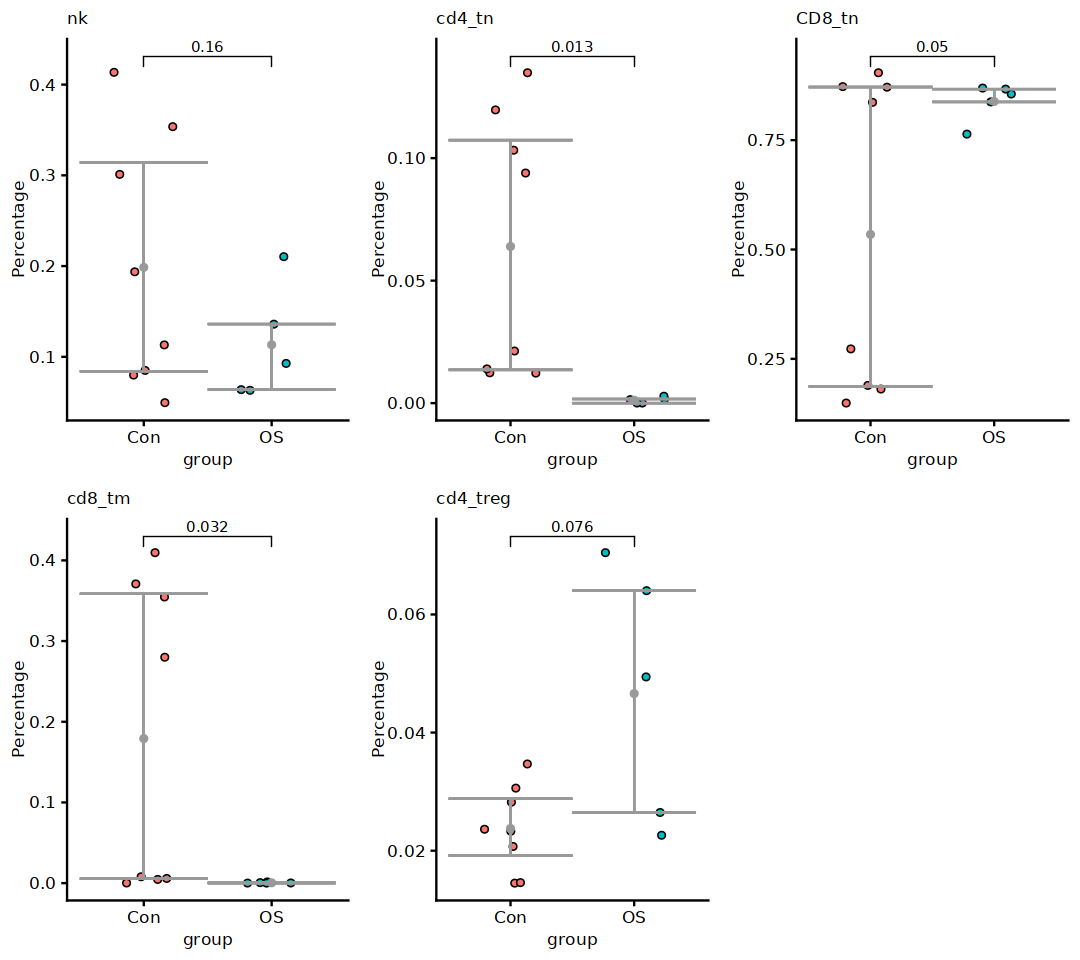

In [17]:
library(cowplot)
plot_grid(pplist[[1]],
          pplist[[2]],
          pplist[[3]],
          pplist[[4]],
          pplist[[5]])


          C1           C2           C3           C4           S1           S2 
        4271         4403         4528         3901          490         1210 
          S3           S4 WH2109002886 WH2109013167 WH2112008442 WH2201006389 
         644         1641         1781          653          529          687 
WH2203005877 
         707 


       nk    cd4_tn    CD8_tn    cd8_tm  cd4_treg 
0.2464531 0.0782079 0.4106504 0.2390253 0.0256632 

          
             OS control
  nk        471    5800
  cd4_tn      6    1984
  CD8_tn   3670    6779
  cd8_tm      2    6080
  cd4_treg  208     445

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."
Warning message:
"The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
i Please use the `linewidth` argument instead."
Warning message:
"package 'ggalluvial' was built under R version 4.2.3"


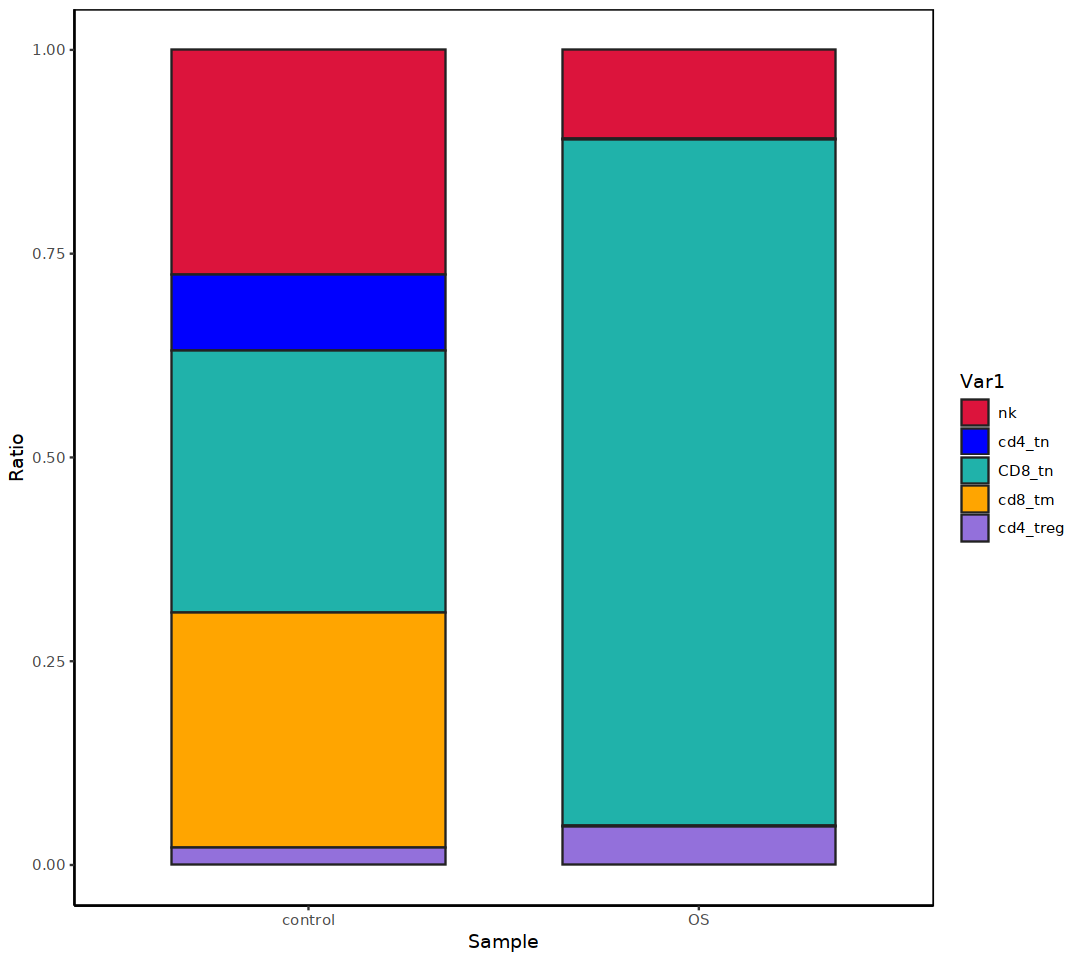

In [18]:
Idents(scRNA) ='celltype'

scedata = scRNA
table(scedata$orig.ident)#查看各组细胞数
prop.table(table(Idents(scedata)))
table(Idents(scedata), scedata$group)#各组不同细胞群细胞数
Cellratio <- prop.table(table(Idents(scedata), scedata$group), margin = 2)#计算各组样本不同细胞群比例
Cellratio <- as.data.frame(Cellratio)

Cellratio$Var2 = factor(Cellratio$Var2,levels = c('control','OS'))

allcolour=c("#DC143C","#0000FF","#20B2AA","#FFA500","#9370DB","#98FB98","#F08080","#1E90FF","#7CFC00","#FFFF00",
            "#808000","#FF00FF","#FA8072","#7B68EE","#9400D3","#800080","#A0522D","#D2B48C","#D2691E","#87CEEB","#40E0D0","#5F9EA0",
            "#FF1493","#0000CD","#008B8B","#FFE4B5","#8A2BE2","#228B22","#E9967A","#4682B4","#32CD32","#F0E68C","#FFFFE0","#EE82EE",
            "#FF6347","#6A5ACD","#9932CC","#8B008B","#8B4513","#DEB887")
library(ggplot2)
ggplot(Cellratio) + 
  geom_bar(aes(x =Var2, y= Freq, fill = Var1),stat = "identity",width = 0.7,size = 0.5,colour = '#222222')+ 
  theme_classic() +
  labs(x='Sample',y = 'Ratio')+
  scale_fill_manual(values = allcolour)+
  theme(panel.border = element_rect(fill=NA,color="black", size=0.5, linetype="solid"))

library(Seurat)
library(ggplot2)
library(dplyr)
library(ggalluvial)

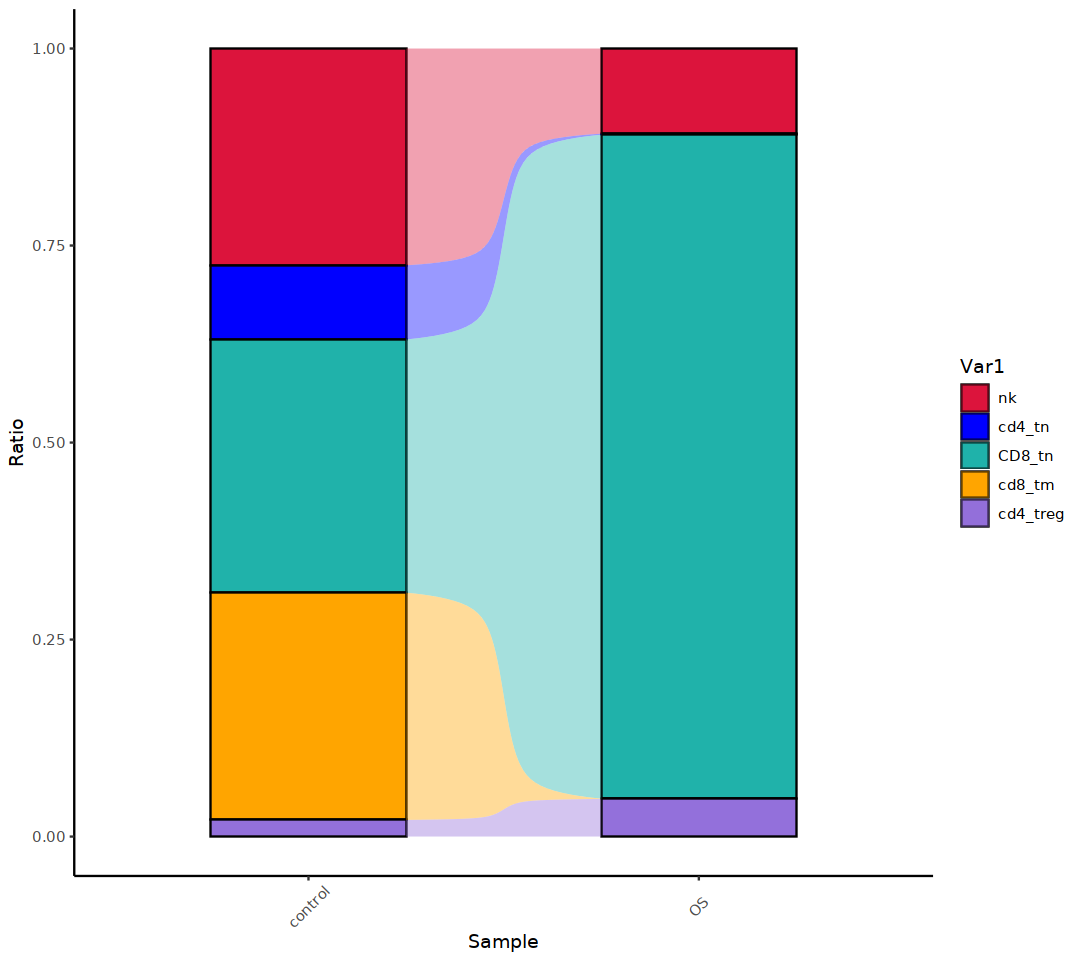

In [19]:
ggplot(Cellratio, aes(x =Var2, y= Freq, fill = Var1,
                  stratum=Var1, alluvium=Var1)) +
  geom_col(width = 0.5, color='black')+
  geom_flow(width=0.5,alpha=0.4, knot.pos=0.5)+ # 参数knot.pos设置为0.5使连接为曲线面积，就像常见的桑基图
  theme_classic() +
  labs(x='Sample',y = 'Ratio')+
  scale_fill_manual(values = allcolour) + theme(axis.text.x = element_text(angle = 45, 
 vjust = 0.5, hjust=0.5))

In [21]:
library(miloR)
library(SingleCellExperiment)
library(scater)
library(scran)
library(dplyr)
library(patchwork)

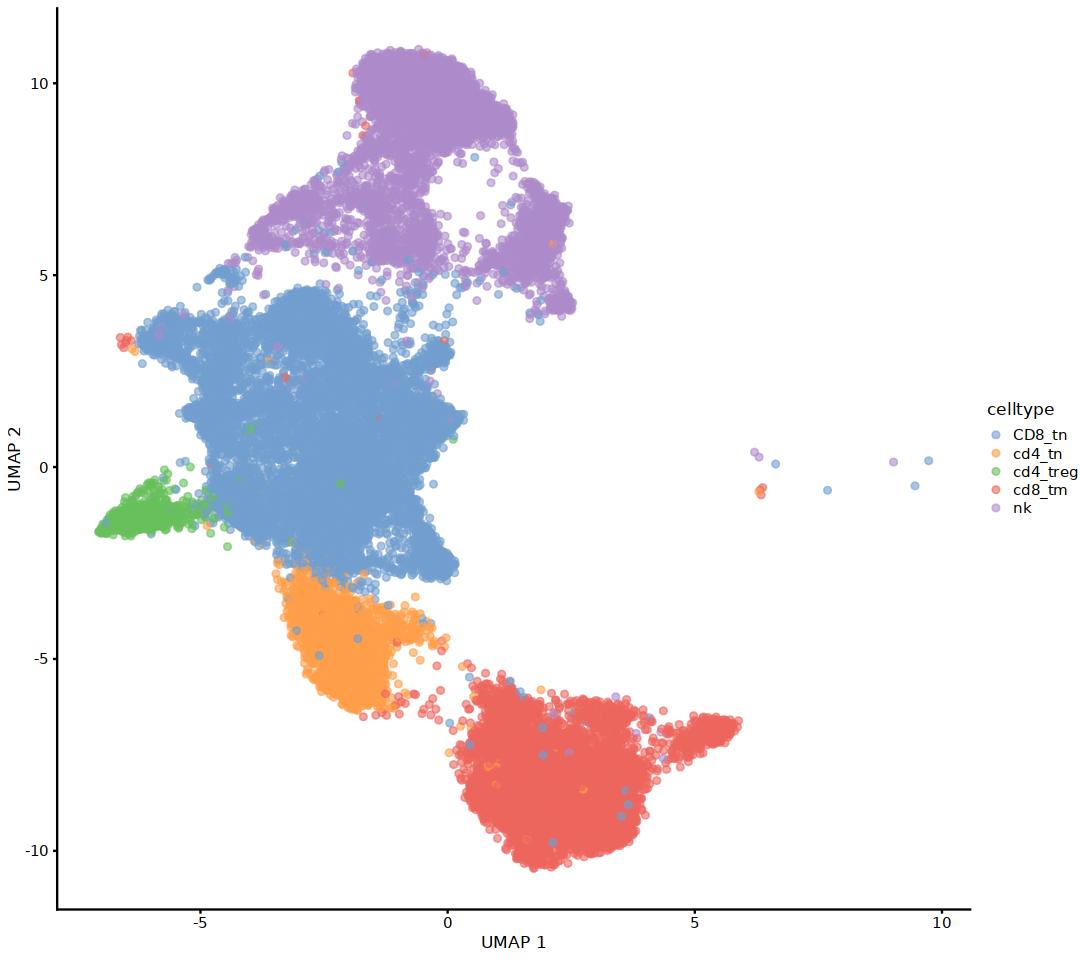

In [22]:
sce <- as.SingleCellExperiment(scedata)
#Visualize the data
plotReducedDim(sce, colour_by="celltype", dimred = "UMAP") 

Constructing kNN graph with k:20

Checking valid object

Running refined sampling with reduced_dim

Checking meta.data validity

Counting cells in neighbourhoods

  [[ suppressing 13 column names 'C1', 'C2', 'C3' ... ]]



6 x 13 sparse Matrix of class "dgCMatrix"
                                 
1 20 31  .  . .  . .  . . . . . .
2  .  .  .  . .  7 2 18 . . . . .
3  .  . 18 16 .  . .  . . . . . .
4 12 15  .  1 .  . .  . . . . . .
5  .  . 27 21 .  . .  . . . . . .
6  .  .  .  . . 33 .  6 . . . . .

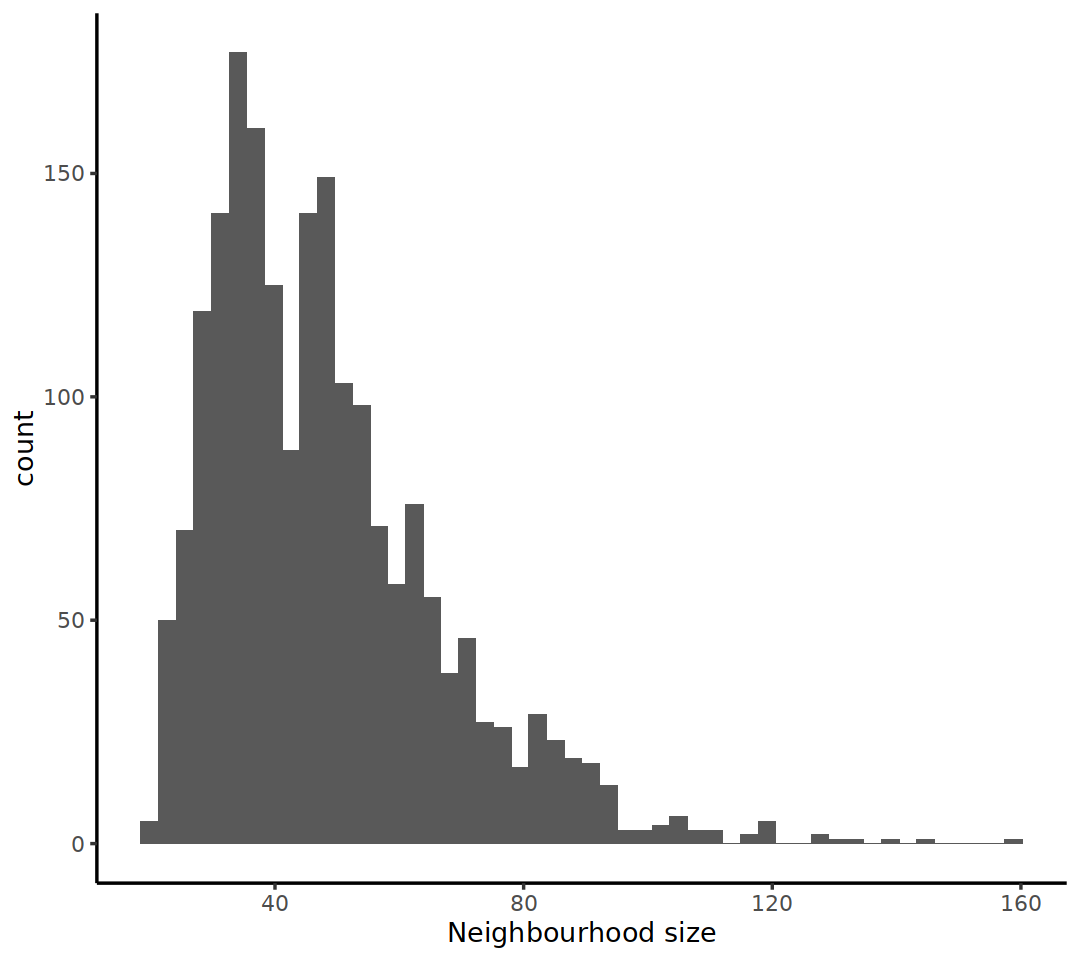

In [23]:
scmilo <- Milo(sce)
#Construct KNN graph
scmilo <- buildGraph(scmilo, k = 20, d = 20,reduced.dim = "PCA")
#Defining representative neighbourhoods on the KNN graph
set.seed(10)
scmilo <- makeNhoods(scmilo, prop = 0.1,
                     k = 20, d = 20, 
                     refined = TRUE, reduced_dims = "PCA")
plotNhoodSizeHist(scmilo)
#Counting cells in neighbourhoods
scmilo <- countCells(scmilo, 
                     meta.data = as.data.frame(colData(scmilo)), 
                     sample = "sample")
head(nhoodCounts(scmilo))

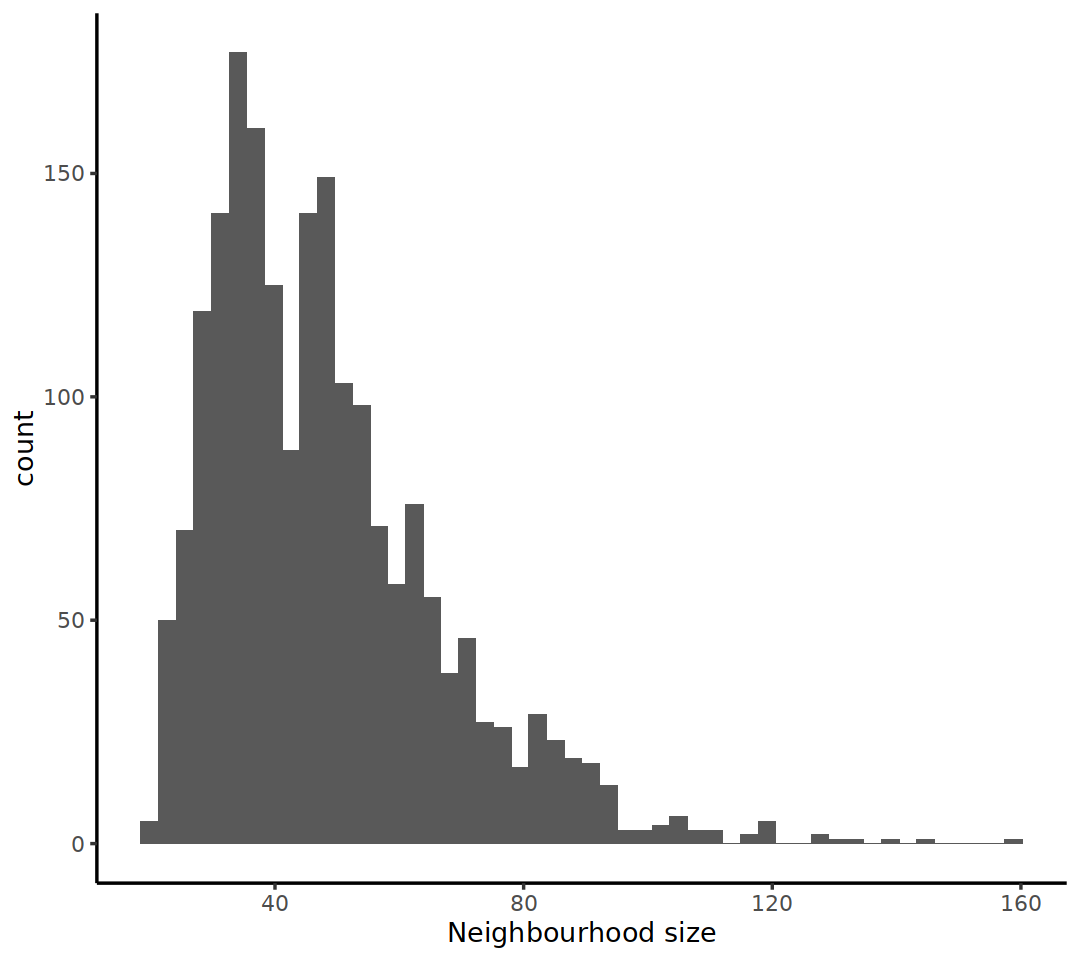

In [24]:
plotNhoodSizeHist(scmilo)

In [ ]:
sc_design <- data.frame(colData(scmilo))[,c("sample", "group")]

sc_design <- distinct(sc_design)
rownames(sc_design) <- sc_design$sample

sc_design <- sc_design[colnames(nhoodCounts(scmilo)), , drop=FALSE]
table(sc_design$group)

In [28]:
table(sc_design$sample)


          C1           C2           C3           C4           S1           S2 
           1            1            1            1            1            1 
          S3           S4 WH2109002886 WH2109013167 WH2112008442 WH2201006389 
           1            1            1            1            1            1 
WH2203005877 
           1 

In [401]:
#odDistance(scmilo, d = 20, reduced.dim = "PCA")

In [29]:
rownames(sc_design) <- sc_design$sample

In [30]:
sc_design

,sample,group
,<chr>,<chr>
C1,C1,control
C2,C2,control
C3,C3,control
C4,C4,control
S1,S1,control
S2,S2,control
S3,S3,control
S4,S4,control
WH2109002886,WH2109002886,OS


In [31]:
sc_design$control = c(rep(1,4),rep(0,5),rep(1,4))
sc_design$OS = c(rep(0,4),rep(1,5),rep(0,4))

In [32]:
sc_design$control  = as.factor(sc_design$control )

In [33]:
sc_design$OS = as.factor(sc_design$OS )

In [34]:
model <- model.matrix(~ 0+group, data=sc_design)

In [35]:
model

,groupOS,groupcontrol
C1,0,1
C2,0,1
C3,0,1
C4,0,1
S1,0,1
S2,0,1
S3,0,1
S4,0,1
WH2109002886,1,0
WH2109013167,1,0


In [37]:
contrast.1 <- c("groupOS -  groupcontrol") # the syntax is <VariableName><ConditionLevel> - <VariableName><ControlLevel>
# we need to use the ~ 0 + Variable expression here so that we have all of the levels of our variable as separate columns in our model matrix
results <- testNhoods(scmilo, design = ~0 + group, design.df = sc_design, model.contrasts = contrast.1,
                         fdr.weighting="graph-overlap", norm.method="TMM")
table(results$SpatialFDR < 0.1)

Using TMM normalisation

Warning message in max(abs(logR)):
"no non-missing arguments to max; returning -Inf"
Performing spatial FDR correction withgraph-overlap weighting




FALSE  TRUE 
 1628   350 

In [38]:
results %>%
  arrange(SpatialFDR) %>%
  head() 

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
16,8.614633,11.20012,13.88957,0.0001943620,0.003710056,16,0.003440953
17,8.989648,11.54919,13.04007,0.0003055819,0.003710056,17,0.003440953
22,8.927883,11.48971,13.19729,0.0002809992,0.003710056,22,0.003440953
25,8.493075,11.09194,13.70240,0.0002147090,0.003710056,25,0.003440953
30,9.006193,11.56283,12.99385,0.0003132132,0.003710056,30,0.003440953
42,8.410400,11.01930,13.57891,0.0002292964,0.003710056,42,0.003440953


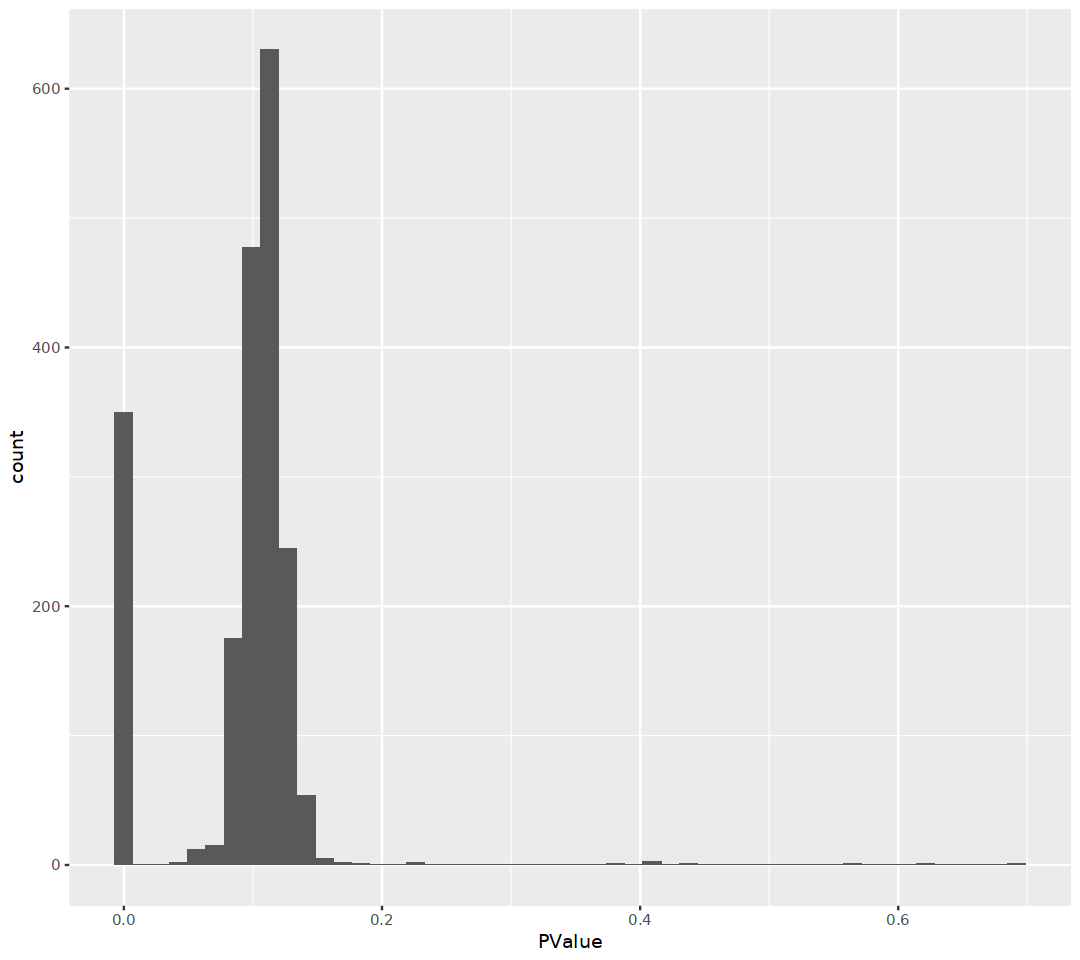

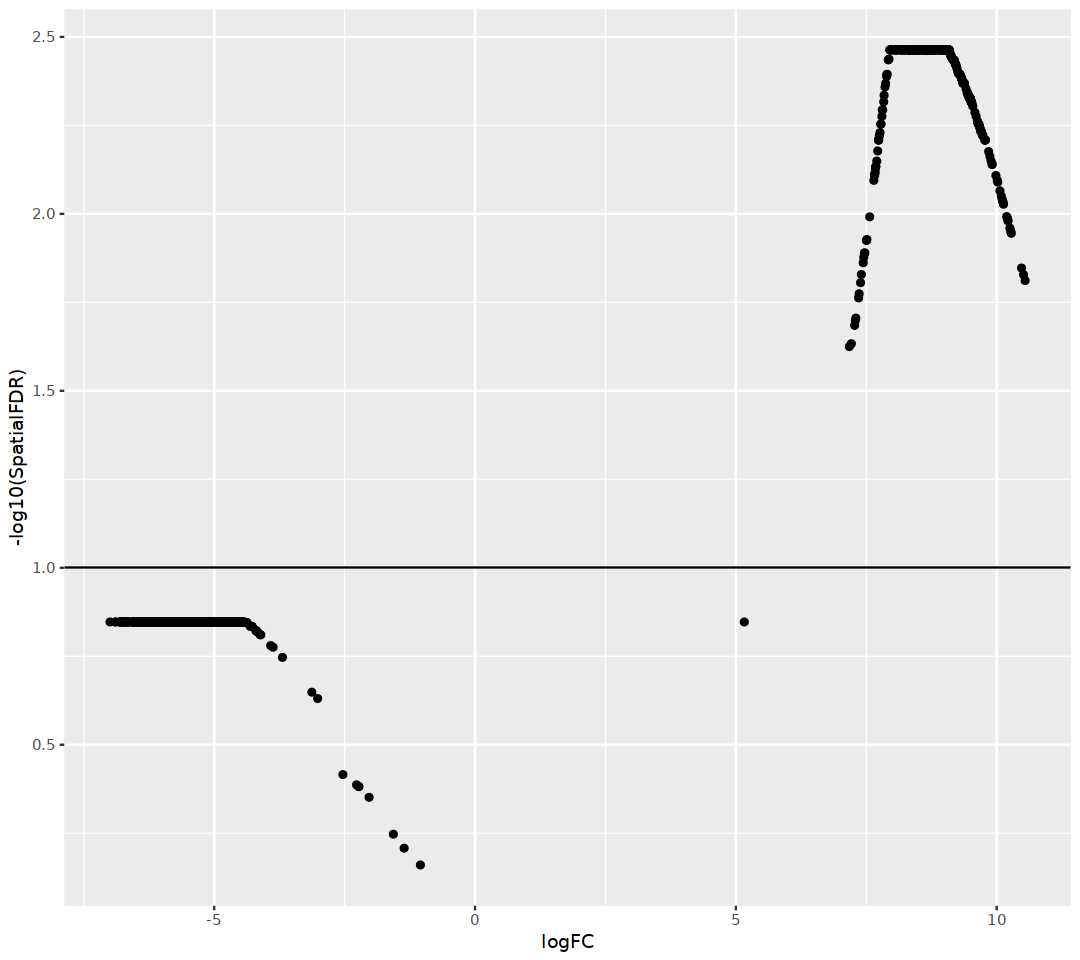

In [39]:
ggplot(results, aes(PValue)) + geom_histogram(bins=50)
ggplot(results, aes(logFC, -log10(SpatialFDR))) + 
  geom_point() +
  geom_hline(yintercept = 1) 

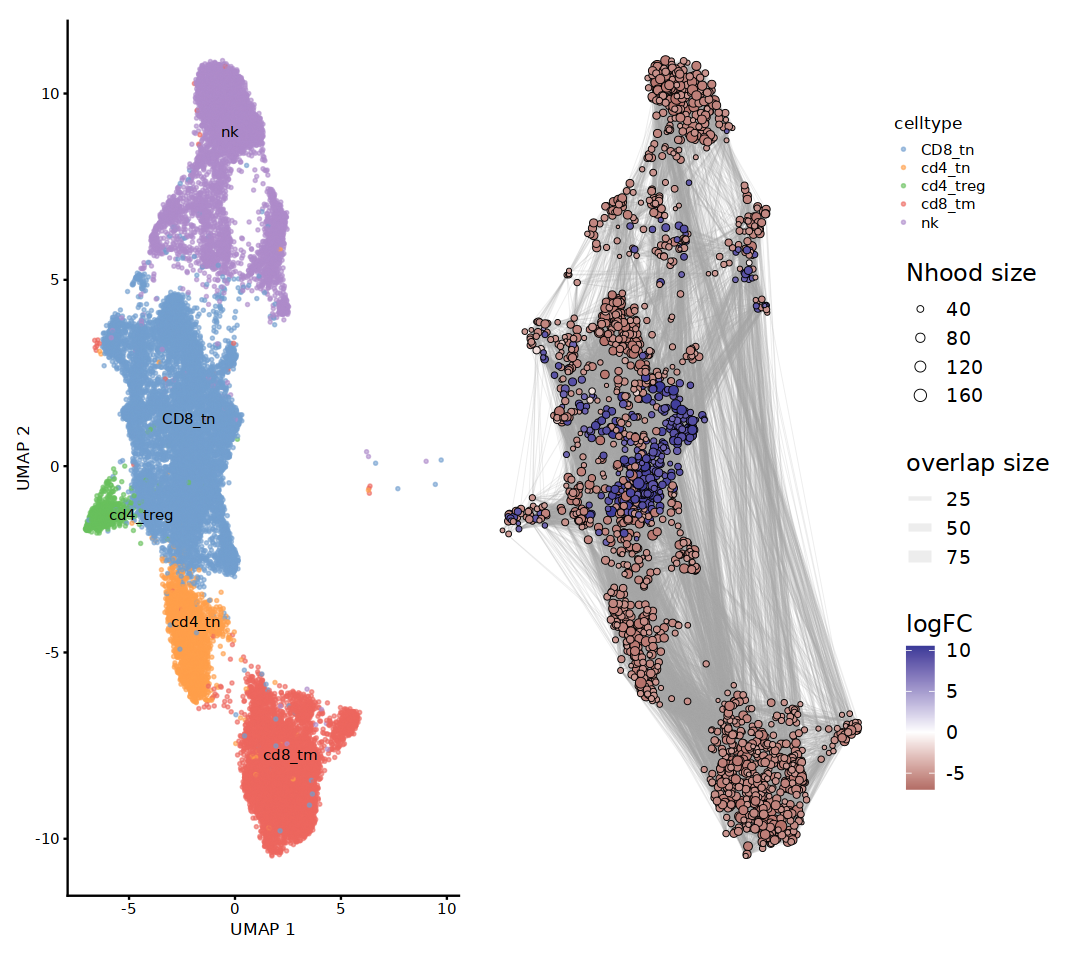

In [40]:
scmilo <- buildNhoodGraph(scmilo)
 
## Plot single-cell UMAP
umap_pl <- plotReducedDim(scmilo, dimred = "UMAP", 
                          colour_by="celltype", text_by = "celltype", 
                          text_size = 3, point_size=0.5) +
  guides(fill="none")
 
## Plot neighbourhood graph
nh_graph_pl <- plotNhoodGraphDA(scmilo, results, layout="UMAP",alpha = 1) 
 
umap_pl + nh_graph_pl +
  plot_layout(guides="collect")

In [41]:
results <- annotateNhoods(scmilo, results, coldata_col = "celltype")

Converting celltype to factor...



In [42]:
table(results$celltype)


  CD8_tn   cd4_tn cd4_treg   cd8_tm       nk 
     829      166       41      510      432 

In [43]:
# https://rdrr.io/github/MarioniLab/miloR/f/vignettes/milo_contrasts.Rmd

Converting group.by to factor...



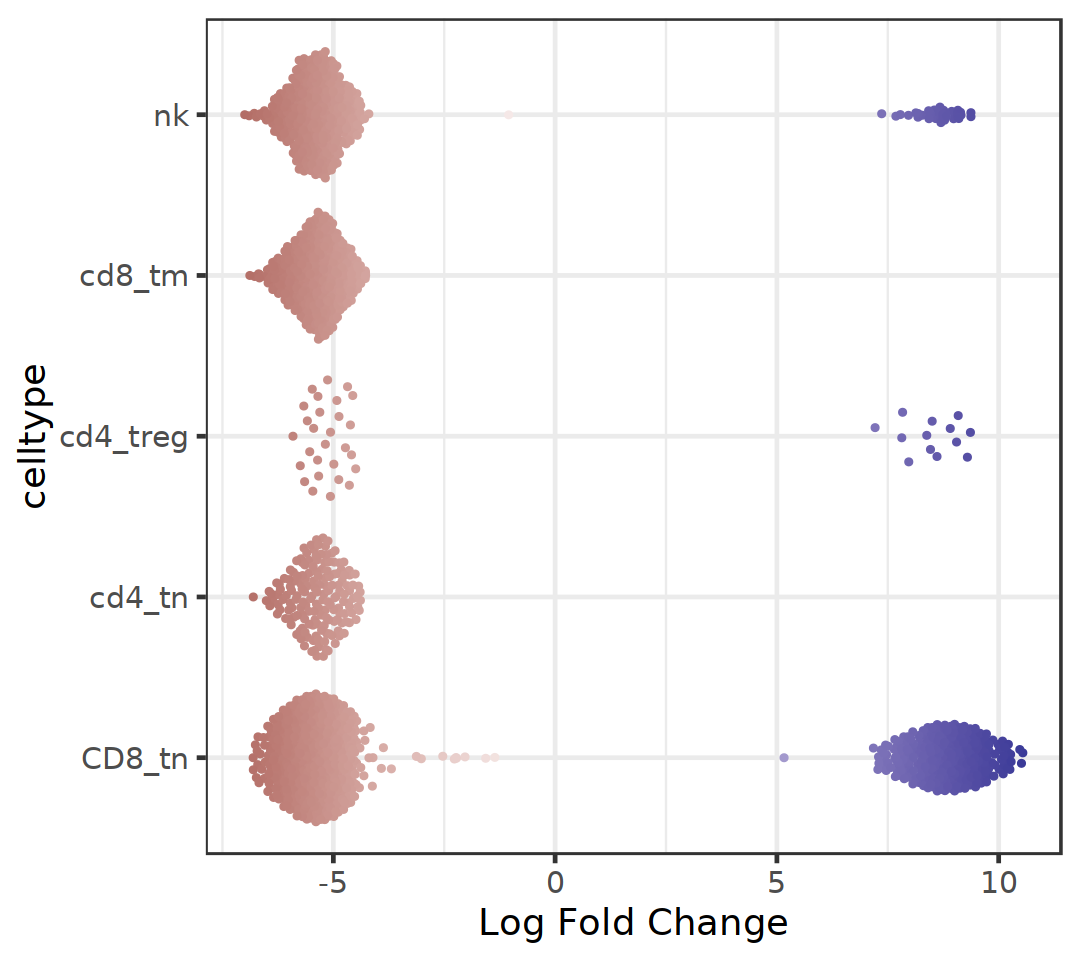

In [44]:
plotDAbeeswarm(results, group.by = "celltype",alpha = 1)